# 第2回: 決定木から始める機械学習

このHands-onでは，機械学習手法のひとつである**決定木**を使って，あらかじめ与えられたデータから，未知データを分類する規則を抽出・適用する**教師あり学習**を体験する．
このHands-onで用いるデータは以下の通り：

* アヤメ（花の種類）のデータ
* タイタニック号の乗船者データ

まず，必要なライブラリを準備しよう．
Google Colaboratory（もしくはJupyter）に
* graphviz
* category_encoders

の2つのライブラリをインストールするために， 以下のコードを実行する．

In [1]:
try:
    import category_encoders
    import graphviz
except:
    !pip install graphviz
    !pip install category_encoders

続けて，必要なライブラリを読み込む．
以下のコードを実行しよう．

In [2]:
# 表形式のデータを操作するためのライブラリ
import pandas as pd

# 行列計算をおこなうためのライブラリ
import numpy as np

# 機械学習用ライブラリsklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz

# その他
import category_encoders

# グラフ描画ライブラリ
from graphviz import Source
import matplotlib.pyplot as plt
%matplotlib inline


---
## 例題1: アヤメ

データマイニングや機械学習を学ぶ際，例題データとしてアヤメ（英語名:Iris）データがよく用いられる（[アヤメ](https://ja.wikipedia.org/wiki/%E3%82%A2%E3%83%A4%E3%83%A1)は植物の1つ）． 
決定木アルゴリズムを体験する題材として，このHands-onでもアヤメデータを使ってみよう．

以下のコードを実行して，アヤメのデータを読み込みむ．

In [3]:
from sklearn import datasets

# Iris（アヤメ）の大きさに関するデータをロード
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['species'] = iris.target_names[iris.target]

# 簡単のために，カラム名を修正しておく
iris_df = iris_df.rename(
    columns = {
        'sepal length (cm)': 'sepal_length',
        'sepal width (cm)': 'sepal_width',
        'petal length (cm)': 'petal_length',
        'petal width (cm)': 'petal_width'
    }
)

# 最初の数件を表示
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


このアヤメデータには，花弁（petal）の長さ・幅，がく（sepal）の長さ・幅，品種が記されている．
例題1の目標は，**花弁の長さ・幅，がくの長さ・幅から品種を推定する予測モデルの構築**である．
早速，決定木を用いて予測モデルを構築してみよう．

一般に教師あり学習で予測を行うモデルを構築する際には，データを**学習用（訓練）データ**と**評価用データ**に分割してデータ分析を行う．
以下のコードを実行して，先ほど用意したデータを学習用（70%）と評価用（30%）に分割する．

In [4]:
# データを学習用（70%）と評価用（30%）に分割する
iris_train_df, iris_test_df = train_test_split(
                                iris_df, test_size=0.3,
                                random_state=1,
                                stratify=iris_df.species)

変数``iris_test_df``には品種情報も含まれる．
予測モデルの性能評価の際には，品種情報が未知であるとして予測を行い，予測結果と（隠しておいた）品種情報を照らし合わせて評価することになる．

では，教師あり学習のひとつである決定木アルゴリズムを適用してみよう．
``iris_train_df``に決定木アルゴリズムを適用して，品種を見分けるルールを抽出（学習）しよう．

決定木アルゴリズムは`sklearn`ライブラリの``DecisionTreeClassifier``クラスを使って実行できる．
下記コードを実行してみよう．

In [5]:
# X_trainは，品種（Species）以外のすべての指標
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
X_train = iris_train_df[features]

# y_trainは品種の指標
y_train = iris_train_df.species

# 学習
model = DecisionTreeClassifier(criterion='entropy',
                               random_state=12345) # 初期値を固定
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=12345)

品種を予測するルールが学習された．
以下のコードを実行して，予測ルールをわかりやすく可視化してみよう．

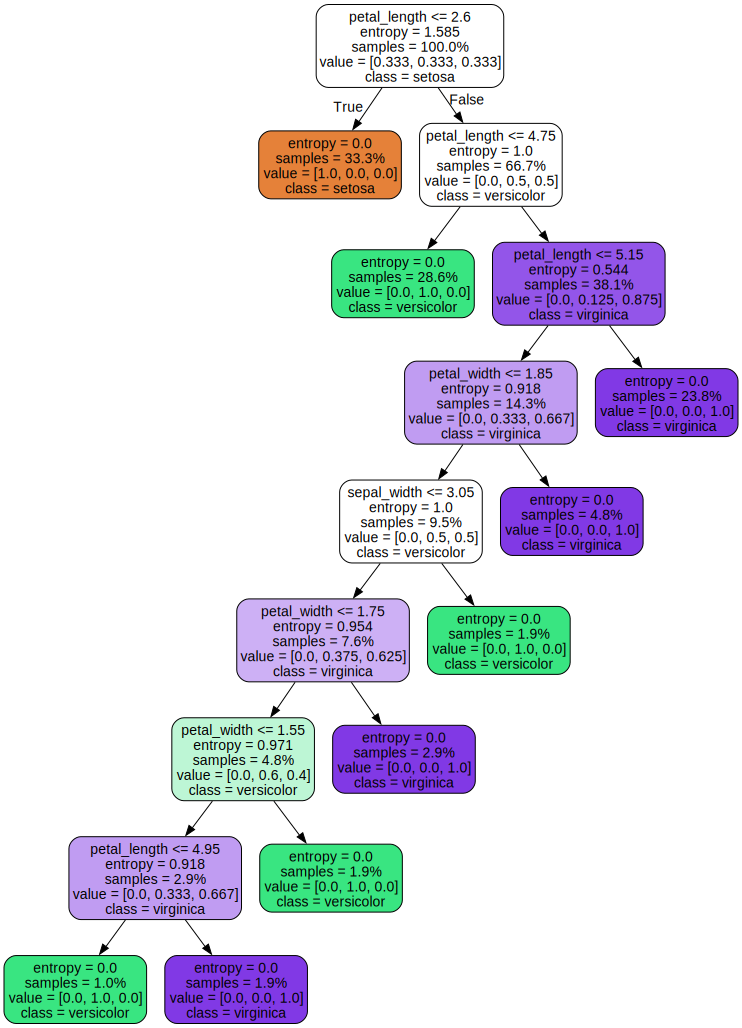

In [6]:
Source(export_graphviz(model, out_file=None,
                       feature_names=features,
                       class_names=['setosa', 'versicolor', 'virginica'],
                       proportion=True,
                       filled=True, rounded=True # 見た目の調整
                      ))

分類ルールが木のように枝分かれした形で可視化された．
この可視化結果が，今回の教師あり学習アルゴリズムが **決定「木」** と呼ばれる所以である．

各四角が分類ルールの分岐を表している．
四角の下に書かれた文字情報が分岐条件を示している．
四角中に書かれた文字は，四角に至るまでに適用された分岐条件を満たすと，
* その条件を満たすデータが全体の何パーセントあるか
* ラベルごとの分類結果の割合が何パーセントか

を示している．
例えば，上図の上から3段目の左にある「class=versicolor, value=\[0.0, 1.00, 0.0\]」という四角は，
* 花弁（petal）の長さが2.6より大きい，かつ花弁（petal）の長さが4.75以下の場合，その個体は100%の確率でversicolorであること
* この条件にマッチする個体はデータセットに28.6%存在すること

を示している．

さて，ここまでやったことは予測のためのルール（モデル）の構築であった．
構築した予測モデルを使って，未知のデータを予測してみよう．
この例題の冒頭で，変数``iris_test_df``に**予測モデルの構築に使われていないデータ**を別途用意していたことを思い出そう．

In [7]:
# 最初の数件を表示
iris_test_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
148,6.2,3.4,5.4,2.3,virginica
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
106,4.9,2.5,4.5,1.7,virginica
75,6.6,3.0,4.4,1.4,versicolor


先ほど構築した予測モデルをこの``iris_test_df``に適用して，未知データのアヤメの品種を予測してみよう．
構築した予測モデル``iris_model``を用いて未知データを予測するには``predict``関数を用いる．

In [8]:
# 評価用データの特徴量と正解ラベルを取得
X_test = iris_test_df[features]
y_test = iris_test_df.species

# 予測モデルを使って，品種が未知の個体の品種を推定
iris_predicted = model.predict(X_test)

# 予測結果の一部を表示
iris_predicted

array(['virginica', 'setosa', 'setosa', 'versicolor', 'versicolor',
       'versicolor', 'virginica', 'versicolor', 'virginica', 'setosa',
       'setosa', 'virginica', 'setosa', 'versicolor', 'setosa',
       'versicolor', 'virginica', 'versicolor', 'versicolor', 'virginica',
       'virginica', 'setosa', 'versicolor', 'virginica', 'versicolor',
       'versicolor', 'versicolor', 'virginica', 'setosa', 'virginica',
       'setosa', 'setosa', 'versicolor', 'versicolor', 'virginica',
       'virginica', 'setosa', 'setosa', 'setosa', 'versicolor',
       'virginica', 'virginica', 'versicolor', 'setosa', 'setosa'],
      dtype=object)

予測結果が変数``iris_predicted``に格納された．
``iris_test_df``の列``Species``には実際の品種情報が格納されていた．これと予測結果と照らし合わせて，予測性能を評価してみよう．

予測性能の評価指標には様々なものがあるが，ここでは精度（accuracy）を計算してみよう．
精度は「予測結果のうち， **各個体の品種について，予測モデルが予測したものと，実際の品種が一致したケースの割合」** を意味する．
精度の計算には`sklearn`の`accuracy_score`関数を用いる．
第1引数に予測結果，第2引数に実際の結果を入力します．以下のコードを実行してみよう．

In [9]:
accuracy_score(iris_predicted, iris_test_df.species)

0.9777777777777777

上記結果によると，Accuracyは約97.8%を示しており，かなりの精度で品種を予測できていることが分かる．


---
## 例題2: タイタニック号の乗船者データ

1912年4月14日，処女航海中の豪華客船タイタニック号は多くの乗船者を乗せたまま沈没した．
タイタニックとその事故は映画化されるなど世界的に有名である．

乗船者に関する情報が残っていたために，事故後，多くの人が事故に関する分析を行った．
私たちもタイタニック号の乗船者情報を用いて，生死を分けた条件について分析を行ってみよう．
以下のコードを実行して，タイタニック号の乗船者（の一部）のデータを読み込もう．

In [10]:
# データの読み込み
url = "https://raw.githubusercontent.com/hontolab-courses/dmml-2022/main/dataset/titanic_train.csv"
titanic_df = pd.read_table(url, header=0, sep=",")

# 生存情報を分かりやすくする
titanic_df = titanic_df.assign(
    Survived = lambda df: df.Survived.map({1: 'survived', 0: 'died'})
)

# 最初の数件のみ表示
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,died,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,survived,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,survived,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,survived,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,died,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


様々な情報が表示された．
変数``titanic_train_df``に格納されたデータの属性（列名）の詳細は以下の通り：

* PassengerId: 乗船者を識別するためのID
* Survived: ある乗船者が沈没事故で生き残った否かを示すフラグ．
* Pclass: チケットの等級．1は1等乗客，2は2等乗客，3は3等乗客を表す
* Name: 乗客名
* Sex: 性別
* Age: 年齢
* SibSp: タイタニック号に同乗した兄弟もしくは配偶者の数
* Parch: タイタニック号に乗船した両親もしくは子どもの数
* Ticket: チケット番号
* Fare: 乗船料金
* Cabin: 客室番号
* Embarked: 乗船した港．C = Cherbourg, Q = Queenstown, S = Southampton

このデータを用いて，どんな乗客が生き残れたのかを予測できるようにしよう．

決定木を適用する前に，``titanic_df``データに対して簡易的な分析を行い，各データ属性と生存情報との関係を眺めてみよう．
以下のコードを実行すると， **乗客の等級（Pclass）と生存の有無（Survived）** の属性の値を集計して，ある等級の乗客のうち生き残った方の割合が表示される．

In [11]:
pd.crosstab(titanic_df['Survived'], titanic_df['Pclass'], normalize='columns')

Pclass,1,2,3
Survived,,,
died,0.37037,0.527174,0.757637
survived,0.62963,0.472826,0.242363


分析の結果，どうやら等級が高い（数値が小さい）ほど生き残っている方の割合が大きいようだ．
等級以外の属性でも同様の分析を行ってみよう．
例えば，性別（Sex）と生存の有無の関係は以下のコードで得られる．

In [12]:
pd.crosstab(titanic_df['Survived'], titanic_df['Sex'], normalize='columns')

Sex,female,male
Survived,,
died,0.257962,0.811092
survived,0.742038,0.188908


決定木アルゴリズムを適用する前に，データの欠損を確認しておこう．
収集したデータの一部が欠損していることはよくある．
欠損値がデータに含まれると，機械学習のアルゴリズムがうまく動作しない場合がある．

欠損値がある場合の対応は，
* 欠損しているデータを捨てる
* 欠損値を代表的な値で埋める

といったアプローチが採られることが多い．
欠損しているデータを捨ててしまうと，学習に用いる貴重なデータが減るので，今回は欠損値を代表値で埋める．

まず，以下のコードを走らせて，欠損値を確認してみよう．

In [13]:
titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

上の結果から，Age，Cabin，Embarkedに欠損値が含まれることが分かる．
Cabinは乗船客に与えられた固有の情報で，生存者の予測には役立たない．
AgeとEmbarkedのみ欠損値を埋めることにしよう．

欠損値を埋めるには様々な方法が提案されているが，今回は
* Ageは中央値
* Embarkedは最頻値

で埋めることにする．
以下のコードを実行しよう．

In [14]:
# Embarkedの欠損を最頻値で埋める
titanic_df["Embarked"] = titanic_df["Embarked"].fillna(titanic_df["Embarked"].mode().iloc[0]) 

# Ageを中央値で埋める
titanic_df["Age"] = titanic_df["Age"].fillna(titanic_df["Age"].median()) 

これで欠損値はなくなった．
それでは決定木アルゴリズムを適用してみよう．
例題1と同様，まず，用意したデータを学習用（70%）と評価用（30%）に分割する．

In [15]:
# データを学習用（70%）と評価用（30%）に分割する
titanic_train_df, titanic_test_df = train_test_split(
                                        titanic_df, test_size=0.3,
                                        random_state=1,
                                        stratify=titanic_df.Survived)

変数``titanic_test_df``には生存の有無の情報も含まれているが，予測モデルの性能評価の際には，生存情報が未知であるとして予測を行い，予測結果と（隠しておいた）生存情報を照らし合わせて評価することになる．

簡易的な分析を行ってみると，生存の有無を識別するために有効な指標がありそうな気もする．
しかし実際には，複数の指標が絡み合って生存の有無が決まっていると思われる．
このような状況で，指標（特徴量）同士の複雑な関係性を考慮しながら，予測のためのルールを抽出するのが**教師あり学習**である．

早速，決定木アルゴリズムを適用してみよう．
まずは決定木を適用するデータを整形する．
データを眺めると，氏名（Name）やチケット番号（Ticket），客室番号（Cabin）は各乗船者に固有に与えられた情報であることが分かる．
これら特徴量は生存者の予測には役に立たないため，それ以外の情報を利用することにする．

下記コードを実行して，決定木を適用する際に注目する指標を，変数``target_features``に格納しておく．
さらに，``titanic_train_df``から上記指標に関するデータのみを抽出する．

In [16]:
# 注目する指標
target_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

# 以下のように書けば，target_featuresの指標のみに注目してデータを抽出できる
titanic_train_df[target_features]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
472,2,female,33.0,1,2,27.7500,S
597,3,male,49.0,0,0,0.0000,S
843,3,male,34.5,0,0,6.4375,C
112,3,male,22.0,0,0,8.0500,S
869,3,male,4.0,1,1,11.1333,S
...,...,...,...,...,...,...,...
650,3,male,28.0,0,0,7.8958,S
241,3,female,28.0,1,0,15.5000,Q
265,2,male,36.0,0,0,10.5000,S
15,2,female,55.0,0,0,16.0000,S


性別（Sex）や乗船した港（Embarked）は数値情報ではなくカテゴリ情報である．
多くの機械学習は数値を受け取って処理をするので，カテゴリ情報も数値情報に変換しておいた方が都合がよい．
ここでは，「EmbarkedがSであることをEmbarked_Sが1，EmbarkedがSでないことをEmbarked_S=0」となるような変換を行う．
この変換は下記コードで行える．

In [17]:
encoder = category_encoders.OneHotEncoder(cols=['Embarked', 'Sex'], use_cat_names=True)
encoder.fit(titanic_train_df[target_features])

OneHotEncoder(cols=['Embarked', 'Sex'], use_cat_names=True)

それでは，``titanic_train_df``に決定木アルゴリズムを適用して，生存の有無のルールを抽出（学習）してみよう．
決定木アルゴリズムは``DecisionTreeClassifier``クラスを用いて実行できる．
下記コードを実行してみよう．

In [18]:
# 予測に用いる生存情報以外のすべての指標をX_trainに
X_train = titanic_train_df[target_features]

# カテゴリ変数を数値情報に変換
X_train = encoder.transform(X_train)

# y_trainは生存有無をあらわす指標
y_train = titanic_train_df.Survived

# 学習
model = DecisionTreeClassifier(criterion='entropy',
                               random_state=12345, # 初期値を固定
                               max_depth=3) # 木の深さを3に限定
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=12345)

生存の有無を予測するルールが学習された．
以下のコードを実行して，生存の有無を予測するためのルールをわかりやすく可視化してみよう．

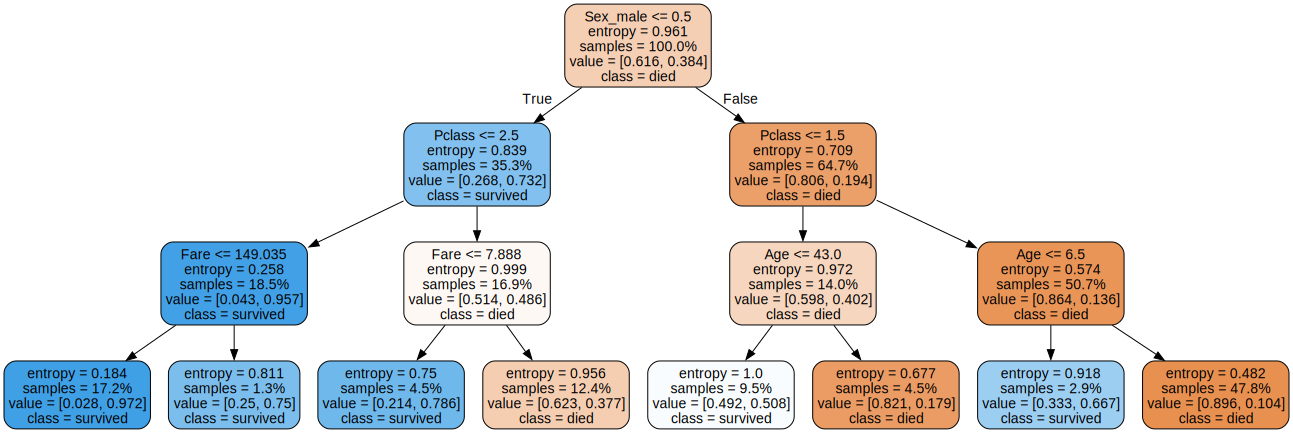

In [19]:
Source(export_graphviz(model, out_file=None,
                       feature_names=X_train.columns,
                       class_names=['died', 'survived'],
                       proportion=True,
                       filled=True, rounded=True # 見た目の調整
                      ))

分類ルールが得られた．

結果を解釈してみよう．
例えば，上図の上から3段目，左端にある「class=survived, entropy=0.258」という四角は，
* 性別が女性であり（Sex_male<=0.5: True），乗船クラスが1等もしくは2等クラス（Pclass<=2.5: True）の乗客は95.7%の確率で生存したこと
* その条件にマッチする乗客は，全体の18.5%存在すること

を示している．

なんとなく予測ルールは分かったが，各指標が予測にどの程度影響があるかを調べてみよう．
以下のコードを実行しよう．

In [20]:
for feature, importance in zip(X_train.columns, model.feature_importances_):
    print("{}\t{}".format(feature, importance))

Pclass	0.2907129831238367
Sex_female	0.0
Sex_male	0.5350835392973032
Age	0.1165652637163436
SibSp	0.0
Parch	0.0
Fare	0.05763821386251649
Embarked_S	0.0
Embarked_C	0.0
Embarked_Q	0.0


この結果からも，**性別**や**等級**が生存に大きく影響を与えていたことがうかがえる．

さて，ここまでやったことは予測のためのルール（モデル）の構築であった．
構築した予測モデルを使って，未知のデータを予測してみよう．
この例題の冒頭で，変数``titanic_test_df``に**予測モデルの構築に使われていないデータ**を別途用意していたことを思い出そう．

In [21]:
# 最初の数件を表示
titanic_test_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
433,434,died,3,"Kallio, Mr. Nikolai Erland",male,17.0,0,0,STON/O 2. 3101274,7.125,NaN,S
221,222,died,2,"Bracken, Mr. James H",male,27.0,0,0,220367,13.000,NaN,S
217,218,died,2,"Jacobsohn, Mr. Sidney Samuel",male,42.0,1,0,243847,27.000,NaN,S
376,377,survived,3,"Landergren, Miss. Aurora Adelia",female,22.0,0,0,C 7077,7.250,NaN,S
447,448,survived,1,"Seward, Mr. Frederic Kimber",male,34.0,0,0,113794,26.550,NaN,S


先ほど構築した予測モデルをこの``titanic_test_df``に適用して，生存の有無を予測してみよう．
構築した予測モデル``model``を用いて未知データを予測するには``predict``メソッドを用いる．

In [22]:
# X_testは，生存情報以外のすべての指標
X_test = titanic_test_df[target_features]

# カテゴリ変数を計算しやすく変換する
X_test = encoder.transform(X_test)

# 予測
y_predicted = model.predict(X_test)

# 予測結果（最初の10件）
y_predicted[:10]

array(['died', 'died', 'died', 'survived', 'survived', 'died', 'died',
       'survived', 'survived', 'died'], dtype=object)

予測結果が変数``y_predicted``に格納された．
``titanic_test_df``の列``Survived``には実際の生存情報が格納されていた．
これと予測結果と照らし合わせて，予測性能を評価してみよう．
以下のコードを実行して，予測性能の評価を行ってみよう．

In [23]:
# y_testは生存の指標
y_test = titanic_test_df.Survived

accuracy_score(y_predicted, y_test)

0.7611940298507462

色々情報が出てきたが，``Accuracy``という数値を見てほしい．
Accuracyは予測結果のうち，**実際に生存した乗客を予測モデルが「生存」と予測し，死亡した乗客を予測モデルが「死亡」と予測できたケースの割合**を意味する．
上記結果によると，Accuracyは約76.1%を示しており，そこそこの割合で生存の有無を予測できていることが分かる．



---

## クイズ

以下のコードを実行して`income_df`に格納されるデータは，ある年にアメリカで実施された国勢調査のデータである．

In [24]:
# データの読み込み
income_df = pd.read_table("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", sep=',', header=None)

# 列名（特徴）に名前を付ける
income_df.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 
                     'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

# データ表示（先頭5件）
income_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


データ中の列名（特徴量）の意味は以下の通りである：

* age: 年齢（整数）
* workclass: 雇用形態（公務員，会社員など）
* fnlwgt: 使わない
* education: 学歴
* education-num: 使わない
* marital-status: 婚姻状態
* occupation: 職業
* relationship: 家族内における役割
* race: 人種
* sex: 性別
* capital-gain: 使わない
* capital-loss: 使わない
* hours-per-week: 週あたりの労働時間（整数値）
* native-country: 出身国
* income: 年収（50Kドル以上，50Kドル未満の二値）

このデータに対して決定木アルゴリズムを適用して，ある人物が年間収入が50Kドル以上か未満かを分類する機械学習モデルを構築したい．

### 課題1
機械学習モデルを構築する前に，基礎データとして`income_df`データに含まれる調査対象者の年齢，性別，年収の分布を知りたい．
年齢に関するヒストグラム（階級数は10）を作成せよ．また，性別（男，女），年収（50K以上，50K未満）について，属性値に対応する人数を求めよ．

* ヒント1: ヒストグラムの作成には`pandas.series.hist`関数を用いるとよい（[参考](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html)）
* ヒント2: 要素の出現頻度を求めるには`pandas.series.value_counts`メソッドを用いるとよい（[参考](https://note.nkmk.me/python-pandas-value-counts/)）

<Axes: >

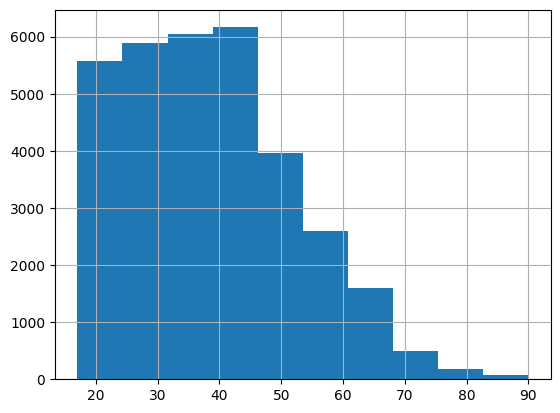

In [25]:
income_df['age'].hist(bins=10)

In [26]:
income_df['sex'].value_counts()

 Male      21790
 Female    10771
Name: sex, dtype: int64

In [27]:
income_df['income'].value_counts()

 <=50K    24720
 >50K      7841
Name: income, dtype: int64

### 課題2
``income_df``データを集約し，学歴ごとに年間収入クラスの内訳（割合）を調べよ．

* ヒント3: pandasのcrosstabメソッドを使う（タイタニックの例を再訪すること）

In [28]:
pd.crosstab(income_df['education'], income_df['income'], normalize='index')

income,<=50K,>50K
education,,
10th,0.933548,0.066452
11th,0.948936,0.051064
12th,0.923788,0.076212
1st-4th,0.964286,0.035714
5th-6th,0.951952,0.048048
7th-8th,0.938080,0.061920
9th,0.947471,0.052529
Assoc-acdm,0.751640,0.248360
Assoc-voc,0.738784,0.261216


### 課題3
`income_df`データに決定木アルゴリズムを適用し，年収（`income`）の分類における各属性（列）の寄与度を求めよ．

In [29]:
# データを学習用（70%）と評価用（30%）に分割する
income_train_df, income_test_df = train_test_split(
                                income_df,
                                test_size=0.3,
                                random_state=1,
                                stratify=income_df.income)

In [30]:
target_features = ['age', 'workclass', 'education', 'marital-status', 'occupation', 
                   'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
encoded_features = ['education', 'workclass', 'marital-status', 'relationship', 'occupation', 'native-country', 'race', 'sex']

encoder = category_encoders.OneHotEncoder(cols=encoded_features, use_cat_names=True)
encoder.fit(income_train_df[target_features])

OneHotEncoder(cols=['education', 'workclass', 'marital-status', 'relationship',
                    'occupation', 'native-country', 'race', 'sex'],
              use_cat_names=True)

In [31]:
# 予測に用いる年収情報以外のすべての指標をX_trainに
X_train = income_train_df[target_features]

# カテゴリ変数を数値情報に変換
X_train = encoder.transform(X_train)

# y_trainは年収クラスをあらわす指標
y_train = income_train_df.income

# 学習
model = DecisionTreeClassifier(criterion='entropy',
                               max_depth=5)
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [32]:
for feature, importance in zip(X_train.columns, model.feature_importances_):
    print("{}\t{}".format(feature, importance))

age	0.0894604682456178
workclass_ Federal-gov	0.0
workclass_ Private	0.0
workclass_ State-gov	0.000640985686209342
workclass_ Self-emp-inc	0.0
workclass_ ?	0.0
workclass_ Local-gov	0.0
workclass_ Self-emp-not-inc	0.0
workclass_ Without-pay	0.0
workclass_ Never-worked	0.0
education_ Bachelors	0.06141563902135156
education_ 10th	0.0
education_ Some-college	0.006168600381132655
education_ 11th	0.0
education_ 12th	0.0
education_ Prof-school	0.003625407861733974
education_ Assoc-voc	0.0
education_ HS-grad	0.00881490359411402
education_ Masters	0.010774717032624306
education_ Doctorate	0.0
education_ Assoc-acdm	0.0
education_ 7th-8th	0.0
education_ 9th	0.0
education_ 1st-4th	0.0
education_ Preschool	0.0
education_ 5th-6th	0.0
marital-status_ Divorced	0.0
marital-status_ Separated	0.0
marital-status_ Married-civ-spouse	0.5943231227829802
marital-status_ Never-married	0.0
marital-status_ Widowed	0.0
marital-status_ Married-spouse-absent	0.0
marital-status_ Married-AF-spouse	0.0
occupation_ Pro

### 課題4
課題3の結果をもとに年収分類に寄与する特徴量を（最大5つ）特定し，その特徴量のみを用いて再度決定木モデルを構築せよ．その際，できる限りシンプルなモデルになるよう，あまり木が深くならないよう調整すること．

In [33]:
target_features = ['age', 'education', 'marital-status', 'occupation', 'hours-per-week']
encoded_features = ['education', 'marital-status', 'occupation']

encoder = category_encoders.OneHotEncoder(cols=encoded_features, use_cat_names=True)
encoder.fit(income_train_df[target_features])

X_train = income_train_df[target_features]
X_train = encoder.transform(X_train)
y_train = income_train_df.income

# 学習
model = DecisionTreeClassifier(criterion='entropy',
                               max_depth=3)
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

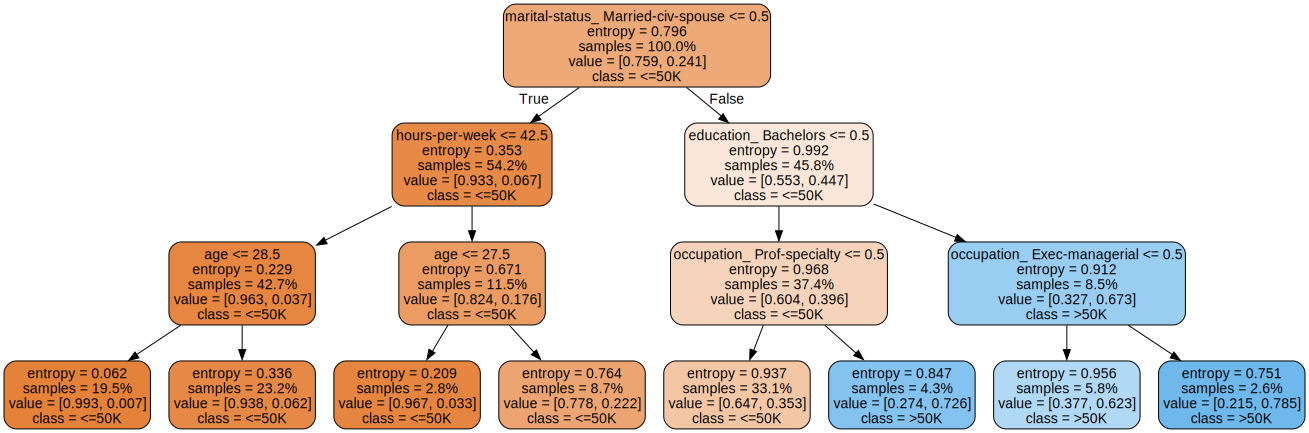

In [34]:
Source(export_graphviz(model, out_file=None,
                       feature_names=X_train.columns,
                       class_names=['<=50K', '>50K'],
                       proportion=True,
                       filled=True, rounded=True # 見た目の調整
                      ))